In [1]:
%load_ext autoreload
%load_ext nb_black
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
from gpu_helper import enable_gpu
enable_gpu()

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


<IPython.core.display.Javascript object>

In [3]:
import tensorflow as tf
import tensorflow_addons as tfa
import transformers
import os
from transformers import GPT2Tokenizer, TFGPT2LMHeadModel, TFGPT2PreTrainedModel
from tensorflow import keras
from toai.imports import *
from gpu_helper import enable_gpu
from model_utils import *
from random import choice

/home/martynas/ml/.venv/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


<IPython.core.display.Javascript object>

In [4]:
#See https://github.com/huggingface/transformers/issues/1843
import logging
logging.getLogger('transformers.tokenization_utils').setLevel(logging.ERROR)

<IPython.core.display.Javascript object>

In [5]:
DATA_DIR = Path("data")
TEMP_DIR = Path("temp")
DATA_DIR.mkdir(parents=True, exist_ok=True)
TEMP_DIR.mkdir(parents=True, exist_ok=True)

<IPython.core.display.Javascript object>

In [6]:
df = pd.read_csv(DATA_DIR/ 'mpst_full_data.csv')

<IPython.core.display.Javascript object>

In [7]:
df.sample(5)

,imdb_id,title,plot_synopsis,tags,split,synopsis_source
7800,tt0057254,The List of Adrian Messenger,A writer named Adrian Messenger (John Merivale...,murder,train,wikipedia
14523,tt0037774,Herr Meets Hare,The cartoon opens with a faux Walter Winchell-...,psychedelic,test,wikipedia
9800,tt0268294,The Fairy Queen,For the plot of the play see A Midsummer Night...,"romantic, fantasy",val,wikipedia
7177,tt6386436,Let It Shine,"In Atlanta, Georgia, Cyrus DeBarge (Tyler Jame...",non fiction,val,wikipedia
3370,tt0112362,Angel Baby,Harry(John Lynch) and Kate(Jacqueline Mckenzie...,romantic,val,imdb


<IPython.core.display.Javascript object>

In [8]:
df.describe()

,imdb_id,title,plot_synopsis,tags,split,synopsis_source
count,14828,14828,14828,14828,14828,14828
unique,14828,13757,13848,5604,3,2
top,tt0080671,The Three Musketeers,Dragon Ball Z picks up five years after the en...,murder,train,wikipedia
freq,1,10,12,1004,9489,10656


<IPython.core.display.Javascript object>

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14828 entries, 0 to 14827
Data columns (total 6 columns):
imdb_id            14828 non-null object
title              14828 non-null object
plot_synopsis      14828 non-null object
tags               14828 non-null object
split              14828 non-null object
synopsis_source    14828 non-null object
dtypes: object(6)
memory usage: 695.2+ KB


<IPython.core.display.Javascript object>

In [10]:
df['plot_length'] = df['plot_synopsis'].apply(len)

<IPython.core.display.Javascript object>

In [11]:
df.describe()

,plot_length
count,14828.000000
mean,5139.938090
std,4939.950638
min,442.000000
25%,2494.750000
50%,3827.000000
75%,5760.000000
max,63959.000000


<IPython.core.display.Javascript object>

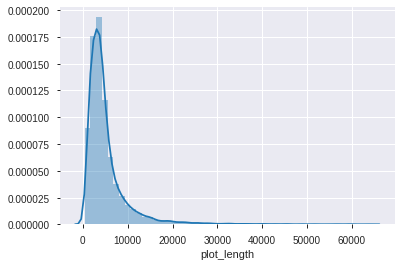

<IPython.core.display.Javascript object>

In [12]:
sns.distplot(df['plot_length']);

## Text generation with generic pretraned GPT2 model

In [29]:
model = TFGPT2LMHeadModel.from_pretrained("gpt2-medium")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2-medium")
tokenizer.pad_token = '<|pad|>'
tokenizer.special_tokens_map

100%|██████████| 456318/456318 [00:00<00:00, 738969.31B/s]


{'bos_token': '<|endoftext|>',
 'eos_token': '<|endoftext|>',
 'unk_token': '<|endoftext|>',
 'pad_token': '<|pad|>'}

<IPython.core.display.Javascript object>

In [30]:
def make_pred(text, model, tok, p=0.8):
    input_ids = tf.constant(tok.encode(text))
    logits = model(input_ids)[0][-1]
    probs = tf.math.softmax(logits, axis=-1).numpy()
    idxs = np.argsort(probs)[::-1]
    res, cumsum = [], 0.
    for idx in idxs:
        res.append(idx)
        cumsum += probs[idx]
        if cumsum > p:
            c = choice(res)
            pred_idx = c
            break
    return tok.decode(int(pred_idx))

<IPython.core.display.Javascript object>

In [31]:
def generate_text(seed, word_count):
    for _ in range(20):
        seed = seed + make_pred(seed, model, tokenizer)
    
    return seed

<IPython.core.display.Javascript object>

In [32]:
for _ in range(5):
    print(generate_text("This AI homework project", 30))
    print("-----")

This AI homework project doesn't even deal with nouns (since this would conflict with Quinyana language), it only
-----
This AI homework project by Elias Mack in Le Soir reveals one fascinating possibility about upcoming smartphone 4K screens and/or
-----
This AI homework project showed off her dexterity at supernova form the Maxent article and good random reading abilities that had that
-----
This AI homework project seems similar to Jack Craver's Grift Tree machine; they create mathematical content based on searching algorithm
-----
This AI homework project would only require people to ask you to compute/document one puzzle piece on their behalf to evaluate you
-----


<IPython.core.display.Javascript object>

## Finetune GPT2 model to generate movie plots

In [33]:
BATCH_SIZE = 32

<IPython.core.display.Javascript object>

In [34]:
#lets take small part of dataset for testing purposes
df = df.sample(500)

<IPython.core.display.Javascript object>

In [35]:
def tokenize_and_pad(arr, tokenizer, sequence_length):
    return np.array(
        [
            np.pad(
                tokenizer.encode(x, add_special_tokens=True),
                (0, sequence_length),
                "constant",
                constant_values=tokenizer.pad_token_id,
            )[:sequence_length]
            for x in arr
        ]
    )

<IPython.core.display.Javascript object>

In [36]:
data = tokenize_and_pad(df['plot_synopsis'].values, tokenizer, 500)
data.shape

(500, 500)

<IPython.core.display.Javascript object>

In [37]:
xs, ys = data[:,:-1],data[:,-1]
xs.shape, ys.shape

((500, 499), (500,))

<IPython.core.display.Javascript object>

In [38]:
def make_gpt2_dataset(x, y, tokenizer):
    features = tf.data.Dataset.from_tensor_slices(x)
    labels = tf.data.Dataset.from_tensor_slices(y)
    dataset = tf.data.Dataset.zip((features, labels))
    return dataset.cache().repeat().shuffle(len(x)).batch(BATCH_SIZE).prefetch(-1)
    
        
       

<IPython.core.display.Javascript object>

In [39]:
train_gpt2_dataset = make_gpt2_dataset(xs, ys, tokenizer)

<IPython.core.display.Javascript object>

In [40]:
for xs, ys in train_gpt2_dataset.take(1):
    print(xs.shape, ys.shape)
    print(xs)
    print(ys)

(32, 499) (32,)
tf.Tensor(
[[  464  3807  9808 ...  2925 26148   284]
 [ 5432    12  4579 ... 50256 50256 50256]
 [34007  1029    12 ...   284 42905   683]
 ...
 [   32 21757  2933 ...   679  2925   625]
 [44045   357    42 ... 23030   621  1683]
 [ 3791  1971  4287 ...  9852 17424   319]], shape=(32, 499), dtype=int64)
tf.Tensor(
[ 7765 50256    13 20729   465  7438 50256  5221 16252  5436   465 11078
 50256    13   283 19478   309  1364   257  3409   311   329   393   428
 13606 50256  2496  8404 41373   284    13  1016], shape=(32,), dtype=int64)


<IPython.core.display.Javascript object>

In [41]:
model.summary()

Model: "tfgp_t2lm_head_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer (TFGPT2MainLayer multiple                  354823168 
Total params: 354,823,168
Trainable params: 354,823,168
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>

In [42]:
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=1e-3),
)

<IPython.core.display.Javascript object>

In [43]:
train_data_steps = len(data) // BATCH_SIZE

<IPython.core.display.Javascript object>

Failure starts here. Prime suspect is `gpt2-medium` model. As per description
>24-layer, 1024-hidden, 16-heads, 345M parameters.
>OpenAI’s Medium-sized GPT-2 English model

It has 24 layers and the error below states: 
>Expected to see 25 array(s), but instead got the following list of 1 arrays:

In [44]:
history = model.fit(
    train_gpt2_dataset,
    steps_per_epoch=train_data_steps,
    epochs=2,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.3, patience=1),
        keras.callbacks.EarlyStopping(
            monitor="loss", patience=3, restore_best_weights=True
        ),
    ],
)

Train for 15 steps
Epoch 1/2
 1/15 [=>............................] - ETA: 0sWARNING:tensorflow:Reduce LR on plateau conditioned on metric `loss` which is not available. Available metrics are: lr


ValueError: Error when checking model target: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 25 array(s), but instead got the following list of 1 arrays: [<tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=int64>]...

<IPython.core.display.Javascript object>